In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
off_diag_elems = torch.ones(3)
diag_elems = torch.ones(4)

In [5]:
# fill elements
prec = torch.diag_embed(diag_elems) + torch.diag_embed(off_diag_elems, offset=1, dim1=-2, dim2=-1)
# cov = torch.inverse(prec)
# plt.imshow()
print(prec, prec @ prec.transpose(-1, -2))

tensor([[1., 1., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]]) tensor([[2., 1., 0., 0.],
        [1., 2., 1., 0.],
        [0., 1., 2., 1.],
        [0., 0., 1., 1.]])


In [10]:
batch, time = diag_elems.shape
device = diag_elems.device
prec2 = torch.zeros(batch, time, time, device=device)
a_2 = diag_elems**2
b_2 = torch.cat([torch.zeros(batch, 1, device=device), off_diag_elems**2], dim=1)
ab = diag_elems[:, :-1] * off_diag_elems            
prec2 += torch.diag_embed(a_2+b_2, dim1=-2, dim2=-1)
off_diagonal = torch.diag_embed(ab, offset=1, dim1=-2, dim2=-1)            
prec2 += off_diagonal + off_diagonal.transpose(-2, -1)

In [11]:
# check diff between prec1 and prec2
print(torch.norm(prec1 - prec2))

tensor(0.)


In [ ]:
l = 100
d = 5
mu1 = torch.zeros(l, d)
sigma1 = torch.eye(d, d).repeat(l, 1, 1)
mu = torch.randn(l, d)
A = torch.tril(torch.randn(l, d, d))
# make diagonal positive
diag = torch.diagonal(A, dim1=-2, dim2=-1)        
diag = nn.Softplus()(diag)
# set diag of A to diag
A = A - torch.diag_embed(torch.diagonal(A, dim1=-2, dim2=-1)) + torch.diag_embed(diag)

In [ ]:
p = torch.distributions.MultivariateNormal(mu1, scale_tril=sigma1)
q = torch.distributions.MultivariateNormal(mu, scale_tril=A)
# compute the kl divergence
kl_loss = torch.distributions.kl_divergence(q, p).sum()
print(kl_loss)

In [ ]:
cov = torch.bmm(A, torch.transpose(A, 1, 2))
det = torch.det(cov)
kl_loss = 0.5 * torch.sum(torch.sum(mu.pow(2), dim=1) + torch.einsum("...ii", cov) - mu.shape[1] - torch.log(det))
print(kl_loss, 'original')

In [ ]:
batch, dim, time = 10, 5, 100
bd = torch.randn(batch, time, 2*dim)
prec = torch.zeros(batch, dim, time, time)
for i in range(dim):
    diag_elems = bd[:, :, i]
    off_diag_elems = bd[:, :-1, i+dim]
    # fill elements
    prec[:, i, :, :] = torch.diag_embed(diag_elems) + torch.diag_embed(off_diag_elems, offset=1, dim1=-2, dim2=-1)
    prec[:, i, :, :] = torch.bmm(prec[:, i, :, :].transpose(1, 2), prec[:, i, :, :])
    print(prec[0, i, :, :])

In [2]:
from vae_unimodal import TimeSeries

In [9]:
a = TimeSeries(10, 8, 2, 25, False, 1, False, 0.1)

In [10]:
y = torch.randn(5, 25, 10)

In [17]:
out = a.forward(y)
out[0].sample_n(10).shape

/Users/mithileshvaidya/miniforge3/lib/python3.10/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


torch.Size([10, 5, 25])

In [9]:
# create matrix with 1 on diagonala and off diagonal
a = torch.eye(5, 5)
# put 1 on off diagonal
a += torch.diag_embed(torch.ones(4), 1)
# print(a.T @ a)
print(torch.linalg.inv(a.T @ a))

tensor([[ 5., -4.,  3., -2.,  1.],
        [-4.,  4., -3.,  2., -1.],
        [ 3., -3.,  3., -2.,  1.],
        [-2.,  2., -2.,  2., -1.],
        [ 1., -1.,  1., -1.,  1.]])


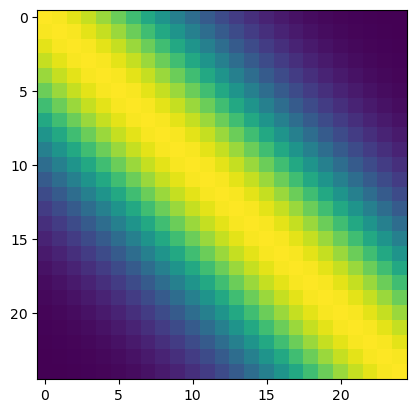

In [3]:
from vae_gp import rbf_kernel
import matplotlib.pyplot as plt
import torch
a = rbf_kernel(25, 7) + 1e-6 * torch.eye(25)
plt.imshow(a)

In [3]:
from vae_gp_combined import CustomDistribution
import torch.distributions as dist
import torch

In [9]:
m, a = torch.randn(5, 10), torch.randn(5, 10, 10)
a = CustomDistribution(m, a)
print(a.kl_divergence_normal())

tensor(215.5961)


In [10]:
d = dist.MultivariateNormal(m, covariance_matrix=a.get_covariance_matrix())

In [11]:
print(dist.kl_divergence(d, dist.MultivariateNormal(torch.zeros(5, 10), torch.eye(10))).sum())

tensor(215.5961)


In [9]:
from vae_gp import derivative_time_series
import torch
import matplotlib.pyplot as plt
# sine wave of 10 points
x = torch.linspace(0, 1, 10)
y = torch.sin(3.14 * x).unsqueeze(0).unsqueeze(-1)

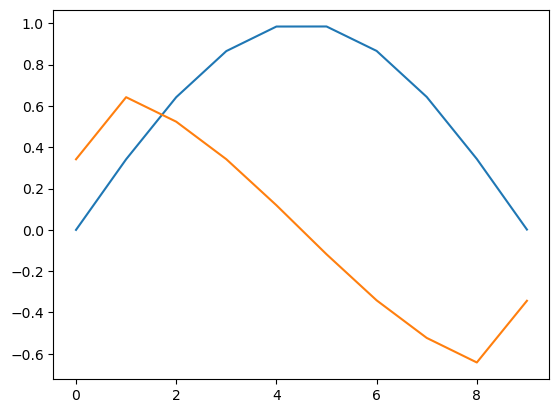

In [10]:
dx = derivative_time_series(y)
plt.plot(y[0, :, 0].numpy())
plt.plot(dx[0, :, 0].numpy())
plt.show()

In [13]:

batch_size, z_size, time_length = 1, 2, 10
mapped = torch.randn(batch_size, time_length, 3*z_size)
# Obtain mean and precision matrix components
num_dim = len(mapped.shape)
perm = list(range(num_dim - 2)) + [num_dim - 1, num_dim - 2]
mapped_transposed = mapped.permute(perm)
mapped_mean = mapped_transposed[:, :z_size]
mapped_covar = mapped_transposed[:, z_size:]

mapped_covar = torch.nn.functional.softplus(mapped_covar)

mapped_reshaped = mapped_covar.reshape(batch_size, z_size, 2 * time_length)

dense_shape = [batch_size, z_size, time_length, time_length]
idxs_1 = torch.repeat_interleave(torch.arange(batch_size), z_size * (2 * time_length - 1))
idxs_2 = torch.tile(torch.repeat_interleave(torch.arange(z_size), (2 * time_length - 1)), dims=(batch_size,))
idxs_3 = torch.tile(torch.cat([torch.arange(time_length), torch.arange(time_length - 1)]), dims=(batch_size * z_size,))
idxs_4 = torch.tile(torch.cat([torch.arange(time_length), torch.arange(1, time_length)]), dims=(batch_size * z_size,))
idxs_all = torch.stack([idxs_1, idxs_2, idxs_3, idxs_4], dim=1)

# Obtain covariance matrix from precision one
mapped_values = mapped_reshaped[:, :, :-1].reshape(-1)
prec_sparse = torch.sparse_coo_tensor(idxs_all.T, mapped_values, dense_shape)
prec_tril = prec_sparse.to_dense() + torch.eye(prec_sparse.size(-1), device=prec_sparse.device)
cov_tril = torch.linalg.solve(prec_tril, torch.eye(prec_tril.size(-1), device=prec_tril.device))
cov_tril = torch.where(torch.isfinite(cov_tril), cov_tril, torch.zeros_like(cov_tril))

In [16]:
# prec_sparse.to_dense()
torch.norm(prec_tril @ cov_tril - torch.eye(prec_tril.size(-1)))

tensor(3.0947e-07)

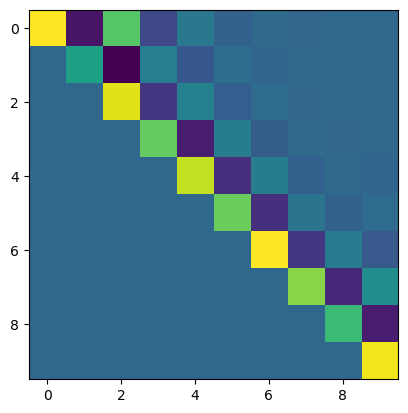

In [19]:
import matplotlib.pyplot as plt
plt.imshow(cov_tril[0, 0])
plt.show()